In [1]:
#####################
# Library imports
#########
import numpy as np
import numpy.linalg as la
import numpy.random as rd
import secrets
import pandas as pd

import matplotlib.pyplot as plt
from pytao import Tao

#####################

In [2]:
#####################
# lattice constants
########
ncell = 75 # number of periodic cells
ncorr = 100 # number of total correctors in the arc
nbpm = 100 # number of total diagnostics (inside the arc)
end_bpm = nbpm+2 # index of the 'end of lattice' bpm

npass = 6 # number of different energies in the lattice
nslice = 6 # number of segments per magnet
nmag = 2 # number of magnets per cell

hold = 12 # number of bpms to freeze per energy
#####################
# number of sims
#######
nlat = 1

bdle = 0.207 * 6
bfle = 0.279 *6

In [3]:
rng = rd.default_rng(secrets.randbits(128)) # initialize rng

# define a truncated normal distribution
def cutnorm(sigma,num):
    # take a regular gaussian
    dist = rng.normal(loc = 0.0, scale = sigma, size=num)
    for i in range(num):
        # remove values that are too large
        if dist[i] > 4*sigma:
            dist[i] = rng.uniform(low = -3*sigma, high = 3*sigma, size = 1)
        # remove values that are too small
        elif dist[i] < -4*sigma:
            dist[i] = rng.uniform(low = -3*sigma, high = 3*sigma, size = 1)
    return np.reshape(dist, num)

(array([  2.,   9.,  53., 147., 247., 258., 172.,  82.,  26.,   4.]),
 array([-3.52814269e-08, -2.84643467e-08, -2.16472665e-08, -1.48301864e-08,
        -8.01310623e-09, -1.19602608e-09,  5.62105408e-09,  1.24381342e-08,
         1.92552144e-08,  2.60722945e-08,  3.28893747e-08]),
 <BarContainer object of 10 artists>)

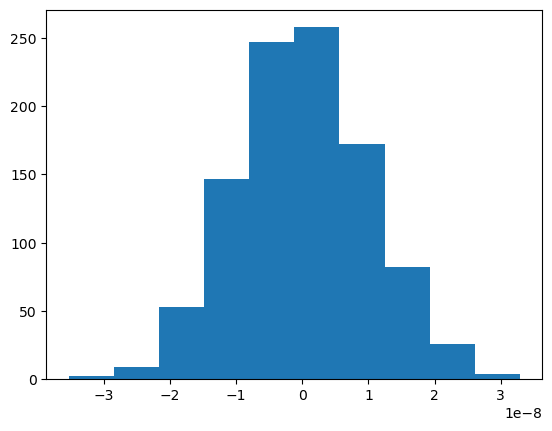

In [11]:
plt.hist(cutnorm(.00000001,1000))

In [4]:
#####################
# random girder offsets
#########

errorgx = np.zeros(ncell*nmag)  # initialize array of girder x offset errors
errorgy = np.zeros(ncell*nmag)
errorgtilt = np.zeros(ncell*nmag)
errorgxp = np.zeros(ncell*nmag)
errorgyp = np.zeros(ncell*nmag)
# set offset values
errorgx = cutnorm(0.00007, nmag*ncell)
errorgy = cutnorm(0.00005, nmag*ncell)
# errorgtilt = cutnorm(0.000001,nmag*ncell)
errorgxp = cutnorm(0.000001, nmag*ncell)
errorgyp = cutnorm(0.000001, nmag*ncell)

# define element and attribute names: the range is due to only offsetting girders
girdx = []
girdy = []
girdtilt = []
girdxp = []
girdyp = []
for i in range(1,76):
    girdx.append(f'set ele *@BFMG##{i} x_offset = '+str(errorgx[2*i-1]))
    girdx.append(f'set ele *@BDMG##{i} x_offset = '+str(errorgx[2*i-2]))
    girdy.append(f'set ele *@BFMG##{i} y_offset = '+str(errorgy[2*i-1]))
    girdy.append(f'set ele *@BDMG##{i} y_offset = '+str(errorgy[2*i-2]))
    girdtilt.append(f'set ele *@BFMG##{i} tilt = '+str(errorgtilt[2*i-1]))
    girdtilt.append(f'set ele *@BDMG##{i} tilt = '+str(errorgtilt[2*i-2]))
    girdxp.append(f'set ele *@BFMG##{i} x_pitch = {errorgxp[2*i-1]}; change ele 
                  *@BFMG##{i} x_offset {0.5*bfle*np.sin(errorgxp[2*i-1]})
    girdxp.append(f'set ele *@BDMG##{i} x_pitch = {errorgxp[2*i-2]}; change ele 
                  *@BDMG##{i} x_offset {0.5*bdle*np.sin(errorgxp[2*i-2]})
    girdyp.append(f'set ele *@BFMG##{i} y_pitch = {errorgxp[2*i-1]}; change ele 
                  *@BFMG##{i} y_offset {0.5*bfle*np.sin(errorgxp[2*i-1]})
    girdyp.append(f'set ele *@BDMG##{i} y_pitch = {errorgxp[2*i-2]}; change ele 
                  *@BDMG##{i} y_offset {0.5*bfle*np.sin(errorgxp[2*i-2]})



    

#####################

In [9]:
tao = Tao('-init tao.init')


bpmdiffs = np.zeros((nlat,npass,nbpm+1)) # bpm offsets 
# design bpm readings
bpmxs = np.asarray([tao.evaluate(f'{u}@lat::orbit.x[1:{nbpm},{end_bpm}]|design') for u in range(1,7)])

hcorr = np.zeros(ncorr) # array of final horizontal corrector strengths
vcorr = np.zeros(ncorr) # array of final vertical corrector strengths
gcorr = np.zeros(ncorr) # array of final gradient corrector strengths




In [10]:

# tao.cmd('veto var b1corr[1:100]; veto var vfld[1:100]')


#####################
# impose errors on lattice
#########
tao.cmd('set global lattice_calc_on = F')
for k in range(len(girdx)):
    # tao.cmd(girdx[k], raises=False)
    # tao.cmd(girdy[k], raises=False)
    # tao.cmd(girdtilt[k], raises=False)
    tao.cmd(girdxp[k], raises=False)
    tao.cmd(girdyp[k], raises=False)
tao.cmd('set global lattice_calc_on = T', raises=False)
# grab the model bpm values
bpmrs = np.asarray([tao.evaluate(f'{u}@lat::orbit.x[1:{nbpm},{end_bpm}]|model') for u in range(1,7)])
# and record the diffs from design
bpmdiffs[0] = bpmrs - bpmxs

# write out the orbits in the error lattice
# for p in range(npass):
#     tao.cmd('write curve r33.all_orbits.c'+str(p+1)+' svd_orbits/error_p'+str(p+1))

#####################
# multi-pass steering algorithm
#########
# the idea here is to correct passes from lowest energy to highest
# allow optimization on data from the current and lower energy passes
# after each pass, freeze the correctors near the end 





In [8]:
%%tao
sho dat

-------------------------
Tao> sho dat

  Name                                 Using for Optimization
  1@twiss.a_mode_beta[1:103]                     Using:
  1@twiss.b_mode_beta[1:102]                     Using:
  1@twiss.a_mode_alpha[1:103]                    Using:
  1@twiss.b_mode_alpha[1:102]                    Using:
  1@eta.x[1:103]                                 Using: 1:103
  1@eta.px[1:102]                                Using: 1:102
  1@eta.y[1:103]                                 Using: 1:103
  1@eta.py[1:102]                                Using: 1:102
  1@orbit.x[1:103]                               Using: 1:103
  1@orbit.px[1:102]                              Using: 1:102
  1@orbit.y[1:103]                               Using: 1:103
  1@orbit.py[1:102]                              Using: 1:102
  1@orbit.unstable[1:1]                          Using: 1
  2@twiss.a_mode_beta[1:103]                     Using:
  2@twiss.b_mode_beta[1:102]                     Using:
  2@twis

In [15]:

# loop over the passes from lowest energy to highest
for u in range(npass):

    # tao.cmd('set default universe = '+str(u+1))
    # restrict diagnostics to current and lower energies
    tao.cmd('use data *@*')
    tao.cmd('use var *')
    tao.cmd('veto data *@orbit.*')
    tao.cmd('veto data *@eta.*')
    if u < 5:
        tao.cmd('veto data ['+str(u+2)+':6]@twiss.*')
    tao.cmd('veto var vfld; veto var hfld')
    # tao.cmd('use data [1:'+str(u+1)+']@orbit.*')
       

    # do corrections on the available lattice
    # print(tao.cmd('sho dat'))
    tao.cmd('run svd', raises=False) 

    tao.cmd('use data *@*')
    tao.cmd('use var *')
    tao.cmd('veto data *@twiss.*')
    if u < 5:
        tao.cmd(f'veto data [{u+2}:6]@eta.*')
        tao.cmd(f'veto data [{u+2}:6]@orbit.*')
    tao.cmd('veto var b1corr')
    # print(np.mean(np.abs(tao.evaluate('var::hfld[:]|model'))))

    tao.cmd('run svd', raises=False)

    # freeze the last 'hold' (a number) bpms
    tao.cmd(f'set data {u+1}@orbit.x[{nbpm-hold+1+u}:'+str(nbpm)+']|weight = 100')
    tao.cmd(f'set data {u+1}@orbit.x[{end_bpm}]|weight = 1000')
    tao.cmd(f'set data {u+1}@orbit.px[{end_bpm}]|weight = 1000')

    tao.cmd(f'set data {u+1}@orbit.y[{nbpm-hold+1+u}:'+str(nbpm)+']|weight = 100')
    tao.cmd(f'set data {u+1}@orbit.y[{end_bpm}]|weight = 1000')
    tao.cmd(f'set data {u+1}@orbit.py[{end_bpm}]|weight = 1000')

    tao.cmd(f'set data {u+1}@eta.x[{nbpm-hold+1+u}:'+str(nbpm)+']|weight = 100')
    tao.cmd(f'set data {u+1}@eta.x[{end_bpm}]|weight = 1000')
    tao.cmd(f'set data {u+1}@eta.px[{end_bpm}]|weight = 1000')

    tao.cmd(f'set data {u+1}@eta.y[{nbpm-hold+1+u}:'+str(nbpm)+']|weight = 100')
    tao.cmd(f'set data {u+1}@eta.y[{end_bpm}]|weight = 1000')
    tao.cmd(f'set data {u+1}@eta.py[{end_bpm}]|weight = 1000')

    tao.cmd(f'set data {u+1}@twiss.a_mode_beta[{nbpm-hold+1+u}:{nbpm}]|weight = 100')
    tao.cmd(f'set data {u+1}@twiss.a_mode_beta[{end_bpm}]|weight = 1000')

    tao.cmd(f'set data {u+1}@twiss.b_mode_beta[{nbpm-hold+1+u}:{nbpm}]|weight = 100')
    tao.cmd(f'set data {u+1}@twiss.b_mode_beta[{end_bpm}]|weight = 1000')

    tao.cmd(f'set data {u+1}@twiss.a_mode_alpha[{nbpm-hold+1+u}:{nbpm}]|weight = 100')
    tao.cmd(f'set data {u+1}@twiss.a_mode_alpha[{end_bpm}]|weight = 1000')

    tao.cmd(f'set data {u+1}@twiss.b_mode_alpha[{nbpm-hold+1+u}:{nbpm}]|weight = 100')
    tao.cmd(f'set data {u+1}@twiss.b_mode_alpha[{end_bpm}]|weight = 1000')

    
        
# record final corrector strengths    
hcorr = tao.evaluate('var::hfld[:]|model')
vcorr = tao.evaluate('var::vfld[:]|model')
gcorr = tao.evaluate('var::b1corr[:]|model')

# for p in range(npass):
#     tao.cmd('write curve r33.all_orbits.c'+str(p+1)+' svd_orbits/correct_p'+str(p+1))
# tao.cmd('exit')
    

In [16]:
%%tao
python merit

-------------------------
Tao> python merit
  1.47187726613918E+01
-------------------------
Tao> 


In [ ]:
design_orbs = [pd.read_csv(f'svd_orbits/design_p{i}.line_dat', sep='\s+', header=0) for i in range(1,7)]
error_orbs = [pd.read_csv(f'svd_orbits/error_p{i}.line_dat', sep='\s+', header=0) for i in range(1,7)]
correct_orbs = [pd.read_csv(f'svd_orbits/correct_p{i}.line_dat', sep='\s+', header=0) for i in range(1,7)]

In [ ]:
s = [np.reshape(design_orbs[i][['x']].values, len(design_orbs[i][['x']].values)) for i in range(6)]
errdiff = [np.reshape(error_orbs[i][['y']].values - design_orbs[i][['y']].values,len(design_orbs[i][['y']].values)) for i in range(6)]
svddiff = [np.reshape(correct_orbs[i][['y']].values - design_orbs[i][['y']].values,len(design_orbs[i][['y']].values)) for i in range(6)]

In [8]:
diffxend = [tao.evaluate(f'{u}@lat::orbit.x[{end_bpm}]|model - {u}@lat::orbit.x[{end_bpm}]|design') for u in range(1,7)]
diffpxend = [tao.evaluate(f'{u}@lat::orbit.px[{end_bpm}]|model - {u}@lat::orbit.px[{end_bpm}]|design') for u in range(1,7)]

for u in range(6):
    print(f'Pass {u-1}: delta x end = {diffxend[u]}: delta px end = {diffpxend[u]}')

Pass 1: delta x end = [1.64380509e-06]: delta px end = [-8.71640837e-07]
Pass 2: delta x end = [9.73355295e-07]: delta px end = [-9.71252587e-07]
Pass 3: delta x end = [6.07113323e-08]: delta px end = [-8.29152259e-09]
Pass 4: delta x end = [-7.32648059e-07]: delta px end = [1.02709225e-07]
Pass 5: delta x end = [-6.21775688e-07]: delta px end = [5.27513517e-07]
Pass 6: delta x end = [-9.9837569e-07]: delta px end = [1.83274381e-06]


In [9]:
print(correctors)

[[ 3.56335661e-03 -8.13007851e-03 -3.68676560e-03 -5.66874407e-03
  -2.79262329e-04  8.53573773e-04 -3.57988171e-03  1.45932470e-02
   7.69481239e-03  1.52149073e-02  2.47744030e-03  1.12412441e-03
  -8.61981831e-03 -1.25453859e-03  2.43327817e-03  5.72091276e-03
  -4.24445381e-03  1.28878806e-03  8.59141853e-03 -1.08470130e-02
  -3.36152845e-03 -5.73062640e-03  4.76155851e-04  1.51563988e-03
   9.59367179e-04 -3.79930259e-03 -1.64199939e-03 -9.96518789e-05
  -1.37165701e-03  2.42850480e-04  2.28346577e-03 -3.42142089e-03
   3.84031346e-03 -6.63098408e-03  5.90513819e-03 -2.76106732e-03
  -2.52869231e-03 -1.46032298e-04  4.25717277e-03  1.75395810e-03
  -7.93066965e-04 -1.70279555e-02 -1.60214076e-02  3.23087009e-03
   5.53873413e-03 -6.28205564e-03  7.19530618e-04  4.95361460e-03
   8.21792325e-03 -1.17180262e-03 -3.47137013e-03 -1.26770427e-03
   2.29409200e-03 -4.81249472e-03 -3.75652984e-03  2.62166895e-03
   4.43568030e-03 -1.22369702e-03  2.21168048e-03 -1.04328651e-03
   2.26812

In [ ]:
# use LaTeX fonts
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure(figsize=(24,16))
fig.suptitle(r'West FFA@CEBAF Arc: Difference Orbits', fontsize = 25)
fig.supxlabel(r'Longitudinal position [m]', fontsize = 20)
fig.supylabel(r' $\Delta x_{design}$, [m]', fontsize = 20)
ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(234)
ax5 = plt.subplot(235)
ax6 = plt.subplot(236)

ax1.plot(s[0], errdiff[0], c='r', linewidth=2, label = r'Uncorrected')
ax1.plot(s[0], svddiff[0], c='b', linewidth=2, label = r'Corrected')
ax1.set_title(r'E = 11.65 GeV', fontsize = 15)
ax1.set_xlim([0,240])
ax1.set_ylim([-0.001,0.001])
ax1.legend()

ax2.plot(s[1], errdiff[1], c='r', linewidth=2, label = r'Uncorrected')
ax2.plot(s[1], svddiff[1], c='b', linewidth=2, label = r'Corrected')
ax2.set_title(r'E = 13.85 GeV', fontsize = 15)
ax2.set_xlim([0,240])
ax2.set_ylim([-0.001,0.001])
ax2.legend()

ax3.plot(s[2], errdiff[2], c='r', linewidth=2, label = r'Uncorrected')
ax3.plot(s[2], svddiff[2], c='b', linewidth=2, label = r'Corrected')
ax3.set_title(r'E = 16.05 GeV', fontsize = 15)
ax3.set_xlim([0,240])
ax3.set_ylim([-0.001,0.001])
ax3.legend()

ax4.plot(s[3], errdiff[3], c='r', linewidth=2, label = r'Uncorrected')
ax4.plot(s[3], svddiff[3], c='b', linewidth=2, label = r'Corrected')
ax4.set_title(r'E = 18.25 GeV', fontsize = 15)
ax4.set_xlim([0,240])
ax4.set_ylim([-0.001,0.001])
ax4.legend()

ax5.plot(s[4], errdiff[4], c='r', linewidth=2, label = r'Uncorrected')
ax5.plot(s[4], svddiff[4], c='b', linewidth=2, label = r'Corrected')
ax5.set_title(r'E = 20.45 GeV', fontsize = 15)
ax5.set_xlim([0,240])
ax5.set_ylim([-0.001,0.001])
ax5.legend()

ax6.plot(s[5], errdiff[5], c='r', linewidth=2, label = r'Uncorrected')
ax6.plot(s[5], svddiff[5], c='b', linewidth=2, label = r'Corrected')
ax6.set_title(r'E = 22.65 GeV', fontsize = 15)
ax6.set_xlim([0,240])
ax6.set_ylim([-0.001,0.001])
ax6.legend()

plt.tight_layout(pad=2.5)
plt.show()

In [17]:
%%tao
exit

-------------------------
Tao> exit
[INFO 2023-NOV-08 08:57:16] tao_command:
    Stopping.
-------------------------
Tao> 


In [ ]:
np.shape(np.arange(1,151,1))

In [ ]:
x = np.arange(1,151,1)
figk = plt.figure(figsize=(12,8))
ak = plt.subplot(111)
ak.scatter(x, correctors[0], label='Pass 1')
ak.scatter(x, correctors[1], label='Pass 2')
ak.scatter(x, correctors[2], label='Pass 3')
ak.scatter(x, correctors[3], label='Pass 4')
ak.scatter(x, correctors[4], label='Pass 5')
ak.scatter(x, correctors[5], label='Pass 6')
plt.show()